# 平均足

In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import datetime
from statistics import mean
from statistics import median
import calendar
import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb
import math
import time

In [2]:
# OANDA API v20の口座IDとAPIトークン(藤沼ver)
accountID = "101-009-12789646-001"
access_token = "8c5facf670b1061d19fe2c9a0874663f-3fcf75eb5ab3078ad10a63015e2d22d7"
# OANDAのデモ口座へのAPI接続
api = API(access_token=access_token, environment="practice")

## 関数定義

In [3]:
# APIから取得したレートをPandasのDataFrameへ
def to_dataframe(r):
    data = []
    for raw in r.response['candles']:
        data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

    # リストからPandas DataFrameへ変換
    df = pd.DataFrame(data)
    df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
    df['Time'] = pd.to_datetime(df['Time'])
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].apply(float)
    return df

In [4]:
# 第何何曜日（第nX曜日）の日付を返す関数
def get_day_of_nth_dow(year, month, nth, dow):
    '''dow: Monday(0) - Sunday(6)'''
    if nth < 1 or dow < 0 or dow > 6:
        return None

    first_dow, n = calendar.monthrange(year, month)
    day = 7 * (nth - 1) + (dow - first_dow) % 7 + 1

    return day if day <= n else None

In [5]:
def get_data(count, gran, year, month, day, hour, minute, second):
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    _from = datetime.datetime(year=year, month=month, day=day,
                              hour=hour, minute=minute, second=second).strftime(fmt)
    params = {
        "count": count,
        "granularity": gran,
        'from': _from,
#         'dailyAlignment': 0
    }
    r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
    api.request(r)
    df = to_dataframe(r)
    return df

In [6]:
def get_data_super(start, end, gran):
    flag = 0
    try:
        # OANDA API v20の口座IDとAPIトークン(藤沼ver)
        accountID = "101-009-12789646-001"
        access_token = "8c5facf670b1061d19fe2c9a0874663f-3fcf75eb5ab3078ad10a63015e2d22d7"
        # OANDAのデモ口座へのAPI接続
        api = API(access_token=access_token, environment="practice")
        # xxxx-xx-xx～xxxx-xx-xx の期間のデータを取得してデータフレームを返す
        s_year, s_month, s_day, s_hour, s_minute, s_second = map(int, start.split('-'))
        e_year, e_month, e_day, e_hour, e_minute, e_second = map(int, end.split('-'))
        fmt = '%Y-%m-%dT%H:%M:00.000000Z'
        from_ = datetime.datetime(year=s_year, month=s_month, day=s_day,
                                  hour=s_hour, minute=s_minute, second=s_second).strftime(fmt)
        to_ = datetime.datetime(year=e_year, month=e_month, day=e_day,
                                hour=e_hour, minute=e_minute, second=e_second).strftime(fmt)
        to_dt = '{}-{}-{} {}:{}:{}'.format(e_year, e_month, e_day, e_hour, e_minute, e_second)
        to_unix = datetime.datetime.strptime(to_dt, '%Y-%m-%d %H:%M:%S').timestamp()
        df = pd.DataFrame()
        # 5000個制限に引っかからなければこっちの処理
        try:
            params = {
                "granularity": gran,
                'from': from_,
                'to': to_
            }
            r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
            api.request(r)
            df = to_dataframe(r)
        # 引っかかればこっちの処理
        except:
            i = True
            while i:
                df_tmp = get_data(count=5000, gran=gran, year=s_year, month=s_month, day=s_day,
                                 hour=s_hour, minute=s_minute, second=s_second)
                # ケツが同じなら止める (最新迄用)
                if df.tail(1).reset_index(drop=True).equals(df_tmp.tail(1).reset_index(drop=True)):
                    i = False
                else:
                    df = pd.concat([df, df_tmp[:-1]], ignore_index=True)
                    index = df_tmp.tail(1).index[0]
                    s_year = df_tmp.iat[index, 0].year
                    s_month = df_tmp.iat[index, 0].month
                    s_day = df_tmp.iat[index, 0].day
                    s_hour = df_tmp.iat[index, 0].hour
                    s_minute = df_tmp.iat[index, 0].minute
                    s_second = df_tmp.iat[index, 0].second
                    # 5000個ずつ取得してエンドの unix 超えたら止める
                    if to_unix < df.iat[df.tail(1).index[0], 0].timestamp():
                        # はみ出した分をここで切り落とす
                        for i in range(len(df.index) - 5000, len(df.index)):
                            if to_unix <= df.iat[i, 0].timestamp():
                                df = df[:i]
                                break
                        i = False
    except ProtocolError:
        if flag > 5:
            pass
        else:
            time.sleep(1)
            get_data_super(start, end, gran)
            flag+=1
    return df

In [7]:
# ストラテジー評価
def get_evaluation(pos_df, return_=False):
    # 勝率
    win_c = pos_df[pos_df['pips'] >=0].shape[0]
    P = win_c / len(pos_df.index)
    # ペイオフレシオ
    win_p = mean(pos_df[pos_df['pips'] >=0]['pips'])
    los_p = mean(pos_df[pos_df['pips'] < 0]['pips']) * (-1)
    R = win_p / los_p
    # プロフィットファクター
    pf = pos_df[pos_df['profit']>0]['profit'].sum() / pos_df[pos_df['profit']<=0]['profit'].sum() * (-1)
    # 期待値
    win_pro = mean(pos_df[pos_df['pips'] >=0]['profit'])
    los_pro = mean(pos_df[pos_df['pips'] < 0]['profit']) * (-1)
    E = P * win_pro - pos_df[pos_df['pips'] < 0].shape[0] / len(pos_df.index) * los_pro
    # 最大ドローダウン
    dd = pos_df.sort_values(by='pips', ascending=True).head(1)['pips'].values[0]
    # ケリー基準
    kly = ((R + 1) * P - 1) / R
    if return_:
        # WP, POR, PF, E, DD, KLY
        return round(P*100, 2), round(R, 4), round(pf, 4), round(E, 3), round(dd, 1), round(kly*100, 2)
    else:
        print('勝率: {:.2f}%'.format(P*100))
        print('ペイオフレシオ: {:.4f}'.format(R))
        print('プロフィットファクター: {:.4f}'.format(pf))
        print('期待値: {:.3f}円'.format(E))
        print('最大ドローダウン: {:.1f}pips'.format(dd))
        print('ケリー基準: {:.2f}%'.format(kly*100))

In [8]:
# プロット
def entry_plot(pos_df, df, type_='head', n=50, m=20, b=3):
    if type_ == 'head':
        indexes = pos_df.head(n).index
    elif type_ == 'lose_head':
        indexes = pos_df[pos_df['pips']<0].head(n).index
    elif type_ == 'win_head':
        indexes = pos_df[pos_df['pips']>=0].head(n).index
    elif type_ == 'sort_t':
        indexes = pos_df.sort_values(by='pips', ascending=True).head(n).index
    elif type_ == 'sort_f':
        indexes = pos_df.sort_values(by='pips', ascending=False).head(n).index
    for idx in indexes:
        entry_date = pos_df[idx:idx+1]['entry_date'].values[0]
        l_or_s = pos_df[idx:idx+1]['l_or_s'].values[0]
        i = df[df['Time']==entry_date].index[0]
        plt.title(entry_date)
        plt.plot(df[i-b:i+m]['Open'], 'C1o', label="Open")
        plt.plot(df[i-b:i+m]['Close'], 'C0o', label="Close")
        plt.vlines(i, df[i-b:i+m]['Close'].max(), df[i-b:i+m]['Close'].min(),
                  "green" if l_or_s =='long' else 'red', linestyles='dashed', label=l_or_s)
        plt.legend()
        plt.show()

## 読み込み

In [9]:
# dfm5 = pd.read_csv('dfm5.csv')
# dfm1 = pd.read_csv('dfm1.csv')

## 平均足データ作成

In [10]:
# 平均足データ作成
def get_heikin_ashi(start, end, gran):
    df = get_data_super(start, end, gran)
    df_tmp = df.copy()
    for i in range(1, len(df_tmp)):
        if i == 1:
            # 始値＝（前日始値＋前日高値＋前日安値＋前日終値）／4
            df_tmp.iat[i, 2] = (df.iat[i-1, 2] + df.iat[i-1, 3] + df.iat[i-1, 4] + df.iat[i-1, 5]) / 4
        else:
            # 始値＝（前日の平均足の始値＋前日の平均足の終値）／2
            df_tmp.iat[i, 2] = (df_tmp.iat[i-1, 2] + df_tmp.iat[i-1, 5]) / 2
        # 終値＝（当日始値＋当日高値＋当日安値＋当日終値）÷4
        df_tmp.iat[i, 2] = (df.iat[i, 2] + df.iat[i, 3] + df.iat[i, 4] + df.iat[i, 5]) / 4
    return df[1:], df_tmp[1:]

## 検証

### BT1

In [11]:
# バックテスト
def back_test(df, heikin, seed_money, lot=1000, kly_rate='None', print_=True):
    pos = 'None'
    fee = 0.002
    assets = seed_money
    profit = 0
    lot_l = []
    side = []
    entry_date = []
    entry_rate_l = []
    exit_date = []
    exit_rate_l = []
    pips_l = []
    profit_l = []
    assets_l = []
    
    # 実行
    for i in range(2, len(df)):
        next_rate = df.iat[i, 2] # 当日始値(entry exit)
        # 1, 2本前の陰陽
        yy1 = 'red' if heikin.iat[i-1, 2] - heikin.iat[i-1, 5] > 0 else 'blue'
        yy2 = 'red' if heikin.iat[i-2, 2] - heikin.iat[i-2, 5] > 0 else 'blue'

        # 上昇トレンドと判断しロング
        if yy2 == 'red' and yy1 == 'blue':
            if pos != 'entry_long':
                # もし逆のポジションを持ってたら利確
                if pos == 'entry_short':
                    exit_rate = next_rate
                    pips = (entry_rate - exit_rate - fee) * 100
                    if kly_rate != 'None':
                        kly = assets * kly_rate
                        lot = math.floor(kly / exit_rate)
                    profit = pips * lot / 100
                    assets = round(assets + profit, 4)
                    lot_l.extend([lot])
                    side.extend(['short'])
                    entry_date.extend([df.iat[tmp_i, 0]])
                    entry_rate_l.extend([entry_rate])
                    exit_date.extend([df.iat[i, 0]])
                    exit_rate_l.extend([exit_rate])
                    pips_l.extend([pips])
                    profit_l.extend([profit])
                    assets_l.extend([assets])
                    if assets < 0:
                        break
                entry_rate = next_rate
                pos = 'entry_long'
                tmp_i = i
            
        # 下降トレンドと判断しショート
        if yy2 == 'blue' and yy1 == 'red':
            if pos != 'entry_short':
                # もし逆のポジションを持ってたら利確
                if pos == 'entry_long':
                    exit_rate = next_rate
                    pips = (exit_rate - entry_rate - fee) * 100
                    if kly_rate != 'None':
                        kly = assets * kly_rate
                        lot = math.floor(kly / exit_rate)
                    profit = pips * lot / 100
                    assets = round(assets + profit, 4)
                    lot_l.extend([lot])
                    side.extend(['long'])
                    entry_date.extend([df.iat[tmp_i, 0]])
                    entry_rate_l.extend([entry_rate])
                    exit_date.extend([df.iat[i, 0]])
                    exit_rate_l.extend([exit_rate])
                    pips_l.extend([pips])
                    profit_l.extend([profit])
                    assets_l.extend([assets])
                    if assets < 0:
                        break
                entry_rate = next_rate
                pos = 'entry_short'
                tmp_i = i
    
    pos_df = pd.DataFrame(data={'lot': lot_l, 'side': side, 'entry_date': entry_date, 'entry_rate': entry_rate_l,
                                'exit_date': exit_date, 'exit_rate': exit_rate_l, 'pips': pips_l, 'profit': profit_l,
                                'assets':assets_l},
                          columns=['lot', 'side', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])
    if print_:
        print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df

In [12]:
# バックテスト簡易版
def back_test_easy(df, heikin):
    pos = 'None'
    fee = 0.002
    profit_list = []
    pos_count = 0
    profit = 0
    
    # 実行
    for i in range(2, len(df)):
        next_rate = df.iat[i, 2] # 当日始値(entry exit)
        # 1, 2本前の陰陽
        yy1 = 'red' if heikin.iat[i-1, 2] - heikin.iat[i-1, 5] > 0 else 'blue'
        yy2 = 'red' if heikin.iat[i-2, 2] - heikin.iat[i-2, 5] > 0 else 'blue'
        
        # 上昇トレンドと判断しロング
        if yy2 == 'red' and yy1 == 'blue':
            if pos != 'entry_long':
                # もし逆のポジションを持ってたら利確
                if pos == 'entry_short':
                    pos_count+=1
                    exit_rate = next_rate
                    profit = entry_rate - exit_rate - fee
                    profit_list.append(profit)
                entry_rate = next_rate
                pos = 'entry_long'
        # 下降トレンドと判断しショート
        if yy2 == 'blue' and yy1 == 'red':
            if pos != 'entry_short':
                # もし逆のポジションを持ってたら利確
                if pos == 'entry_long':
                    pos_count+=1
                    exit_rate = next_rate
                    profit = exit_rate - entry_rate - fee
                    profit_list.append(profit)
                entry_rate = next_rate
                pos = 'entry_short'
        
    print('pos count: {:>8}, profit: {:>10.3f}'.format(pos_count, sum(profit_list)))
#     return pos_count, round(sum(profit_list), 3)

In [287]:
df, heikin = get_heikin_ashi('2010-01-01-00-00-00', '2020-01-01-00-00-00', 'D')

In [288]:
back_test_easy(df, heikin)

pos count:     1486, profit:     10.359


In [271]:
pos_df = back_test(df, heikin, seed_money=1000000)

pos count:  1486, assets: 983697円


In [13]:
# 足検証
gran_df = pd.DataFrame(columns=['gran', 'pos_count', 'profit', 'WP(%)', 'POR', 'PF', 'E(円)', 'DD(pips)', 'KLY(%)'])
pos_list = []
grans = ['M5', 'M10', 'M15', 'M30', 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12', 'D']
grans.reverse()
for gran in grans:
    print('gran: {:>3}, '.format(gran), end='')
    df, heikin = get_heikin_ashi('2010-01-01-00-00-00', '2020-01-01-00-00-00', gran)
    pos_df = back_test(df, heikin, seed_money=1000000, print_=False)
    pos_list.extend([pos_df])
    pos_count, profit = pos_df.shape[0], pos_df['pips'].sum() / 100
    WP, POR, PF, E, DD, KLY = get_evaluation(pos_df, return_=True)
    print('pos count: {:>8}, profit: {:>10.3f}'.format(pos_count, profit))
    tmp_se = pd.Series([gran, pos_count, profit, WP, POR, PF, E, DD, KLY], index=gran_df.columns)
    gran_df = gran_df.append(tmp_se, ignore_index=True)

gran:   D, pos count:     1486, profit:     10.359
gran: H12, pos count:     2774, profit:     42.610
gran:  H8, pos count:     4084, profit:     52.166
gran:  H6, pos count:     5470, profit:      3.523
gran:  H4, pos count:     8174, profit:     -4.883
gran:  H3, pos count:    10825, profit:    -40.225
gran:  H2, pos count:    16404, profit:    -87.336
gran:  H1, pos count:    32813, profit:   -117.552
gran: M30, pos count:    65693, profit:   -256.508
gran: M15, 

From cffi callback <function _verify_callback at 0x0000023F0C8AC7B8>:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\OpenSSL\SSL.py", line 306, in wrapper
    @wraps(callback)
KeyboardInterrupt


NameError: name 'ProtocolError' is not defined

In [14]:
gran_df

,gran,pos_count,profit,WP(%),POR,PF,E(円),DD(pips),KLY(%)
0,D,1486,10.359,37.75,1.6960,1.0286,6.971,-460.9,1.05
1,H12,2774,42.610,38.10,1.7776,1.0943,15.360,-333.4,3.28
2,H8,4084,52.166,38.86,1.7202,1.0933,12.773,-336.4,3.32
3,H6,5470,3.523,37.95,1.6434,1.0052,0.644,-307.8,0.20
4,H4,8174,-4.883,38.29,1.6017,0.9939,-0.597,-266.4,-0.23
5,H3,10825,-40.225,37.16,1.6181,0.9570,-3.716,-267.5,-1.67
6,H2,16404,-87.336,36.91,1.5805,0.9247,-5.324,-360.8,-3.01
7,H1,32813,-117.552,36.58,1.6063,0.9266,-3.582,-360.8,-2.90
8,M30,65693,-256.508,35.67,1.6015,0.8879,-3.905,-150.2,-4.51


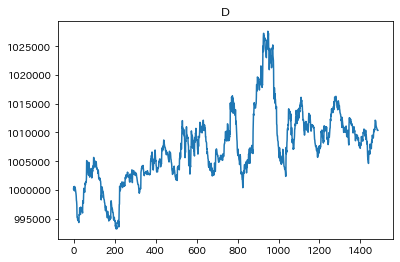

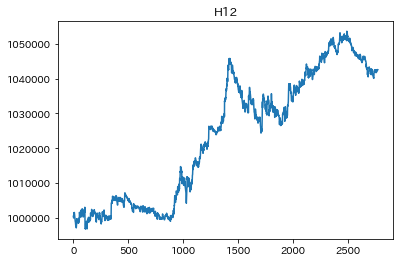

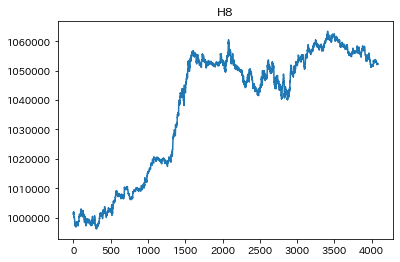

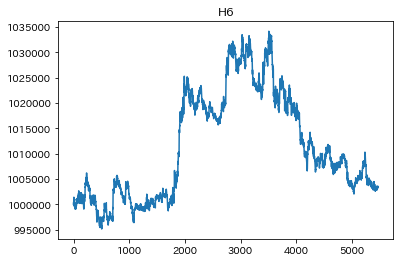

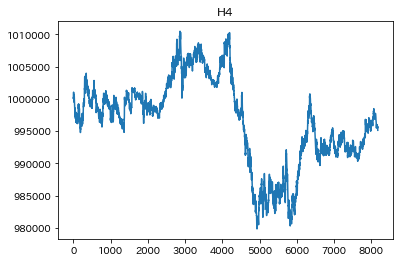

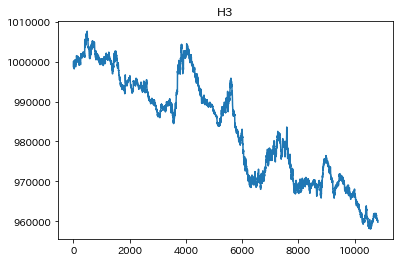

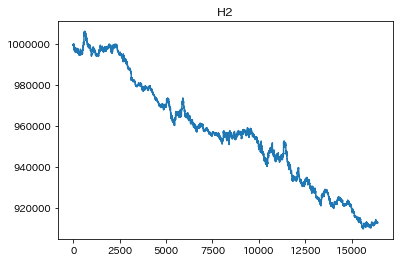

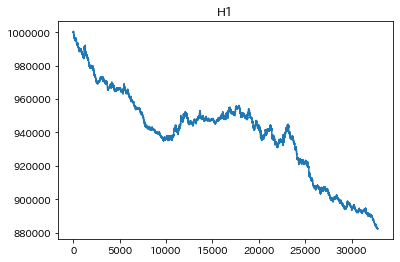

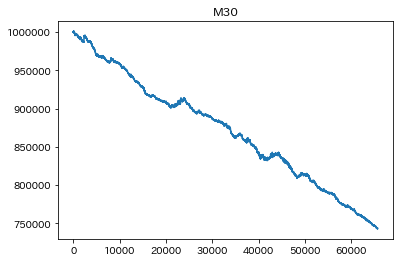

In [28]:
for i in range(len(gran_df)):
    plt.plot(pos_list[i]['assets'])
    plt.title(gran_df.iat[i, 0])
    plt.show()

### BT2

In [21]:
# バックテスト2
def back_test2(df, heikin, seed_money, lot=1000, kly_rate='None', print_=True):
    pos = 'None'
    fee = 0.002
    assets = seed_money
    profit = 0
    lot_l = []
    side = []
    entry_date = []
    entry_rate_l = []
    exit_date = []
    exit_rate_l = []
    pips_l = []
    profit_l = []
    assets_l = []
    
    # 実行
    for i in range(3, len(df)):
        next_rate = df.iat[i, 2] # 当日始値(entry exit)
        # 1, 2, 3本前の陰陽
        yy1 = 'red' if heikin.iat[i-1, 2] - heikin.iat[i-1, 5] > 0 else 'blue'
        yy2 = 'red' if heikin.iat[i-2, 2] - heikin.iat[i-2, 5] > 0 else 'blue'
        yy3 = 'red' if heikin.iat[i-3, 2] - heikin.iat[i-3, 5] > 0 else 'blue'

        # 逆張りショート
        if yy3 == 'red' and yy2 == 'blue' and yy1 == 'blue':
            if pos != 'entry_short':
                # ロング持ってたら利確
                if pos == 'entry_long':
                    exit_rate = next_rate
                    pips = (exit_rate - entry_rate - fee) * 100
                    if kly_rate != 'None':
                        kly = assets * kly_rate
                        lot = math.floor(kly / exit_rate)
                    profit = pips * lot / 100
                    assets = round(assets + profit, 4)
                    lot_l.extend([lot])
                    side.extend(['long'])
                    entry_date.extend([df.iat[tmp_i, 0]])
                    entry_rate_l.extend([entry_rate])
                    exit_date.extend([df.iat[i, 0]])
                    exit_rate_l.extend([exit_rate])
                    pips_l.extend([pips])
                    profit_l.extend([profit])
                    assets_l.extend([assets])
                    if assets < 0:
                        break
                entry_rate = next_rate
                pos = 'entry_short'
                tmp_i = i
            
        # 逆張りロング
        if yy3 == 'blue' and yy2 == 'red' and yy1 == 'red':
            if pos != 'entry_long':
                # ショート持ってたら利確
                if pos == 'entry_short':
                    exit_rate = next_rate
                    pips = (entry_rate - exit_rate - fee) * 100
                    if kly_rate != 'None':
                        kly = assets * kly_rate
                        lot = math.floor(kly / exit_rate)
                    profit = pips * lot / 100
                    assets = round(assets + profit, 4)
                    lot_l.extend([lot])
                    side.extend(['short'])
                    entry_date.extend([df.iat[tmp_i, 0]])
                    entry_rate_l.extend([entry_rate])
                    exit_date.extend([df.iat[i, 0]])
                    exit_rate_l.extend([exit_rate])
                    pips_l.extend([pips])
                    profit_l.extend([profit])
                    assets_l.extend([assets])
                    if assets < 0:
                        break
                entry_rate = next_rate
                pos = 'entry_long'
                tmp_i = i
    
    pos_df = pd.DataFrame(data={'lot': lot_l, 'side': side, 'entry_date': entry_date, 'entry_rate': entry_rate_l,
                                'exit_date': exit_date, 'exit_rate': exit_rate_l, 'pips': pips_l, 'profit': profit_l,
                                'assets':assets_l},
                          columns=['lot', 'side', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])
    if print_:
        print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df

In [22]:
# バックテスト簡易版2
def back_test_easy2(df, heikin):
    pos = 'None'
    fee = 0.002
    profit_list = []
    pos_count = 0
    profit = 0
    
    # 実行
    for i in range(3, len(df)):
        next_rate = df.iat[i, 2] # 当日始値(entry exit)
        # 1, 2, 3本前の陰陽
        yy1 = 'red' if heikin.iat[i-1, 2] - heikin.iat[i-1, 5] > 0 else 'blue'
        yy2 = 'red' if heikin.iat[i-2, 2] - heikin.iat[i-2, 5] > 0 else 'blue'
        yy3 = 'red' if heikin.iat[i-3, 2] - heikin.iat[i-3, 5] > 0 else 'blue'
        
        # 逆張りショート
        if yy3 == 'red' and yy2 == 'blue' and yy1 == 'blue':
            if pos != 'entry_short':
                # もし逆のポジションを持ってたら利確
                if pos == 'entry_long':
                    pos_count+=1
                    exit_rate = next_rate
                    profit = exit_rate - entry_rate - fee
                    profit_list.append(profit)
                entry_rate = next_rate
                pos = 'entry_short'
        # 逆張りロング
        if yy3 == 'blue' and yy2 == 'red' and yy1 == 'red':
            if pos != 'entry_long':
                # もし逆のポジションを持ってたら利確
                if pos == 'entry_short':
                    pos_count+=1
                    exit_rate = next_rate
                    profit = entry_rate - exit_rate - fee
                    profit_list.append(profit)
                entry_rate = next_rate
                pos = 'entry_long'
        
    print('pos count: {:>8}, profit: {:>10.3f}'.format(pos_count, sum(profit_list)))

In [337]:
# easy
grans = ['M5', 'M10', 'M15', 'M30', 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12', 'D']
grans.reverse()
for gran in grans:
    print('gran: {:>3}, '.format(gran), end='')
    df, heikin = get_heikin_ashi('2010-01-01-00-00-00', '2020-01-01-00-00-00', gran)
    back_test_easy2(df, heikin)

gran:   D, pos count:      484, profit:    -16.461
gran: H12, pos count:      916, profit:    -19.265
gran:  H8, pos count:     1380, profit:    -21.505
gran:  H6, pos count:     1740, profit:    -58.800
gran:  H4, pos count:     2634, profit:    -25.405
gran:  H3, pos count:     3542, profit:    -16.279
gran:  H2, pos count:     5417, profit:     43.560
gran:  H1, pos count:    10723, profit:     17.062
gran: M30, pos count:    21395, profit:     26.525
gran: M15, pos count:    43221, profit:     26.414
gran: M10, pos count:    64761, profit:      8.491
gran:  M5, pos count:   128757, profit:     15.826


In [23]:
# 足検証
gran_df2 = pd.DataFrame(columns=['gran', 'pos_count', 'profit', 'WP(%)', 'POR', 'PF', 'E(円)', 'DD(pips)', 'KLY(%)'])
pos_list2 = []
grans = ['M5', 'M10', 'M15', 'M30', 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12', 'D']
grans.reverse()
for gran in grans:
    print('gran: {:>3}, '.format(gran), end='')
    df, heikin = get_heikin_ashi('2010-01-01-00-00-00', '2020-01-01-00-00-00', gran)
    pos_df = back_test2(df, heikin, seed_money=1000000, print_=False)
    pos_list2.extend([pos_df])
    pos_count, profit = pos_df.shape[0], pos_df['pips'].sum() / 100
    WP, POR, PF, E, DD, KLY = get_evaluation(pos_df, return_=True)
    print('pos count: {:>8}, profit: {:>10.3f}'.format(pos_count, profit))
    tmp_se = pd.Series([gran, pos_count, profit, WP, POR, PF, E, DD, KLY], index=gran_df2.columns)
    gran_df2 = gran_df2.append(tmp_se, ignore_index=True)

gran:   D, pos count:      484, profit:    -16.461
gran: H12, pos count:      916, profit:    -19.265
gran:  H8, pos count:     1380, profit:    -21.505
gran:  H6, pos count:     1740, profit:    -58.800
gran:  H4, pos count:     2634, profit:    -25.405
gran:  H3, pos count:     3542, profit:    -16.279
gran:  H2, pos count:     5417, profit:     43.560
gran:  H1, pos count:    10723, profit:     17.062
gran: M30, pos count:    21395, profit:     26.525
gran: M15, pos count:    43221, profit:     26.414
gran: M10, pos count:    64761, profit:      8.491
gran:  M5, pos count:   128757, profit:     15.826


In [345]:
gran_df2

,gran,pos_count,profit,WP(%),POR,PF,E(円),DD(pips),KLY(%)
0,D,484,-16.461,57.64,0.6802,0.9257,-34.010,-1051.6,-4.62
1,H12,916,-19.265,59.06,0.6493,0.9368,-21.032,-697.3,-3.99
2,H8,1380,-21.505,58.26,0.6740,0.9408,-15.583,-644.3,-3.67
3,H6,1740,-58.800,56.78,0.6560,0.8618,-33.793,-549.0,-9.10
4,H4,2634,-25.405,59.49,0.6462,0.9491,-9.645,-456.6,-3.19
5,H3,3542,-16.279,59.80,0.6527,0.9708,-4.596,-457.4,-1.80
6,H2,5417,43.560,61.90,0.6557,1.0652,8.041,-481.4,3.79
7,H1,10723,17.062,61.01,0.6509,1.0185,1.591,-347.6,1.11
8,M30,21395,26.525,60.42,0.6688,1.0209,1.240,-319.4,1.24
9,M15,43221,26.414,60.36,0.6666,1.0149,0.611,-338.2,0.89


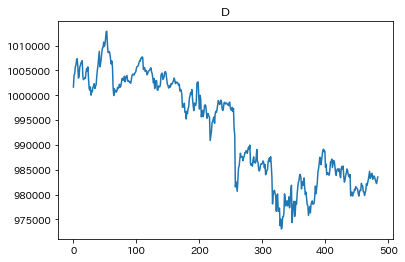

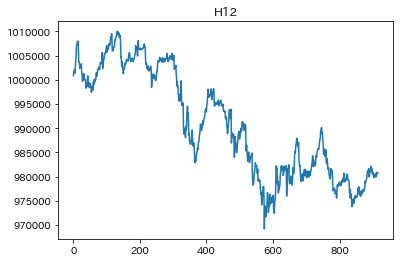

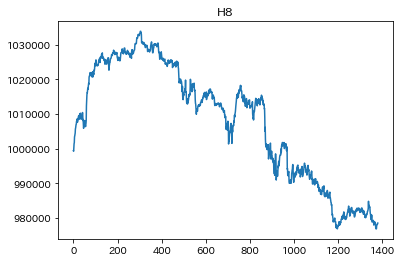

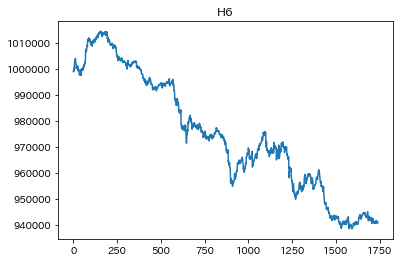

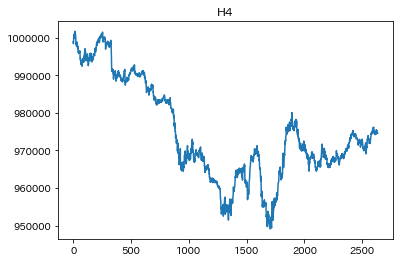

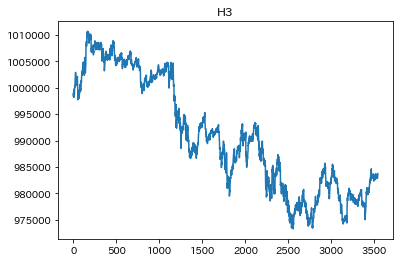

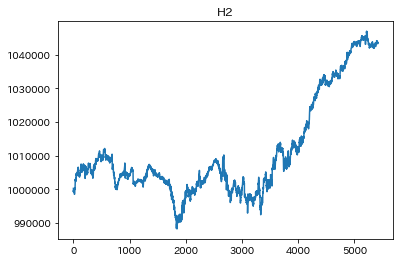

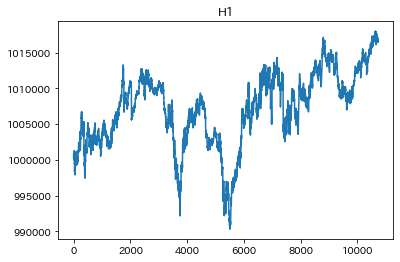

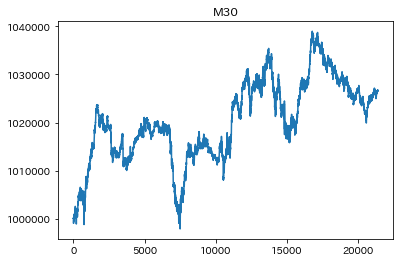

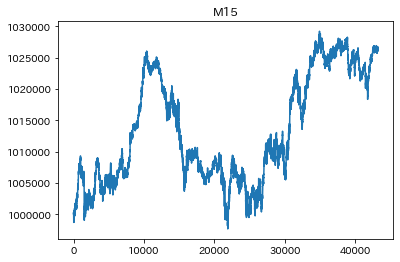

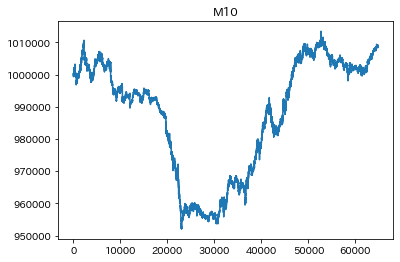

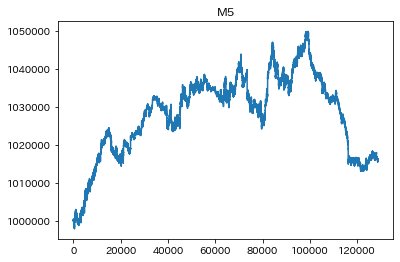

In [29]:
for i in range(len(gran_df2)):
    plt.plot(pos_list2[i]['assets'])
    plt.title(gran_df2.iat[i, 0])
    plt.show()

### BT3

In [31]:
# バックテスト3
def back_test3(df, heikin, seed_money, lot=1000, kly_rate='None', print_=True):
    pos = 'None'
    fee = 0.002
    assets = seed_money
    profit = 0
    lot_l = []
    side = []
    entry_date = []
    entry_rate_l = []
    exit_date = []
    exit_rate_l = []
    pips_l = []
    profit_l = []
    assets_l = []
    
    # 実行
    for i in range(4, len(df)):
        next_rate = df.iat[i, 2] # 当日始値(entry exit)
        # 1, 2, 3, 4本前の陰陽
        yy1 = 'red' if heikin.iat[i-1, 2] - heikin.iat[i-1, 5] > 0 else 'blue'
        yy2 = 'red' if heikin.iat[i-2, 2] - heikin.iat[i-2, 5] > 0 else 'blue'
        yy3 = 'red' if heikin.iat[i-3, 2] - heikin.iat[i-3, 5] > 0 else 'blue'
        yy4 = 'red' if heikin.iat[i-4, 2] - heikin.iat[i-4, 5] > 0 else 'blue'

        # ショート
        if yy4 == 'blue' and yy3 == 'blue' and yy2 == 'red' and yy1 == 'red':
            if pos != 'entry_short':
                # ロング持ってたら利確
                if pos == 'entry_long':
                    exit_rate = next_rate
                    pips = (exit_rate - entry_rate - fee) * 100
                    if kly_rate != 'None':
                        kly = assets * kly_rate
                        lot = math.floor(kly / exit_rate)
                    profit = pips * lot / 100
                    assets = round(assets + profit, 4)
                    lot_l.extend([lot])
                    side.extend(['long'])
                    entry_date.extend([df.iat[tmp_i, 0]])
                    entry_rate_l.extend([entry_rate])
                    exit_date.extend([df.iat[i, 0]])
                    exit_rate_l.extend([exit_rate])
                    pips_l.extend([pips])
                    profit_l.extend([profit])
                    assets_l.extend([assets])
                    if assets < 0:
                        break
                entry_rate = next_rate
                pos = 'entry_short'
                tmp_i = i
            
        # ロング
        if yy4 == 'red' and yy3 == 'red' and yy2 == 'blue' and yy1 == 'blue':
            if pos != 'entry_long':
                # ショート持ってたら利確
                if pos == 'entry_short':
                    exit_rate = next_rate
                    pips = (entry_rate - exit_rate - fee) * 100
                    if kly_rate != 'None':
                        kly = assets * kly_rate
                        lot = math.floor(kly / exit_rate)
                    profit = pips * lot / 100
                    assets = round(assets + profit, 4)
                    lot_l.extend([lot])
                    side.extend(['short'])
                    entry_date.extend([df.iat[tmp_i, 0]])
                    entry_rate_l.extend([entry_rate])
                    exit_date.extend([df.iat[i, 0]])
                    exit_rate_l.extend([exit_rate])
                    pips_l.extend([pips])
                    profit_l.extend([profit])
                    assets_l.extend([assets])
                    if assets < 0:
                        break
                entry_rate = next_rate
                pos = 'entry_long'
                tmp_i = i
    
    pos_df = pd.DataFrame(data={'lot': lot_l, 'side': side, 'entry_date': entry_date, 'entry_rate': entry_rate_l,
                                'exit_date': exit_date, 'exit_rate': exit_rate_l, 'pips': pips_l, 'profit': profit_l,
                                'assets':assets_l},
                          columns=['lot', 'side', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])
    if print_:
        print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df

In [33]:
# 足検証
gran_df3 = pd.DataFrame(columns=['gran', 'pos_count', 'profit', 'WP(%)', 'POR', 'PF', 'E(円)', 'DD(pips)', 'KLY(%)'])
pos_list3 = []
grans = ['M5', 'M10', 'M15', 'M30', 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12', 'D']
grans.reverse()
for gran in grans:
    print('gran: {:>3}, '.format(gran), end='')
    df, heikin = get_heikin_ashi('2010-01-01-00-00-00', '2020-01-01-00-00-00', gran)
    pos_df = back_test3(df, heikin, seed_money=1000000, print_=False)
    pos_list3.extend([pos_df])
    pos_count, profit = pos_df.shape[0], pos_df['pips'].sum() / 100
    WP, POR, PF, E, DD, KLY = get_evaluation(pos_df, return_=True)
    print('pos count: {:>8}, profit: {:>10.3f}'.format(pos_count, profit))
    tmp_se = pd.Series([gran, pos_count, profit, WP, POR, PF, E, DD, KLY], index=gran_df3.columns)
    gran_df3 = gran_df3.append(tmp_se, ignore_index=True)

gran:   D, pos count:      257, profit:    -19.732
gran: H12, pos count:      584, profit:     -0.884
gran:  H8, pos count:      822, profit:    -11.868
gran:  H6, pos count:      995, profit:     34.374
gran:  H4, pos count:     1517, profit:     22.040
gran:  H3, pos count:     2051, profit:    -39.759
gran:  H2, pos count:     3252, profit:    -21.413
gran:  H1, pos count:     6413, profit:     -8.856
gran: M30, pos count:    12385, profit:    -43.213
gran: M15, pos count:    25283, profit:    -87.231
gran: M10, pos count:    37822, profit:   -163.011
gran:  M5, pos count:    76051, profit:   -331.168


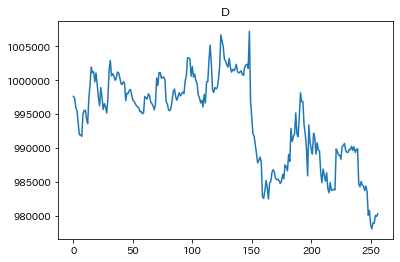

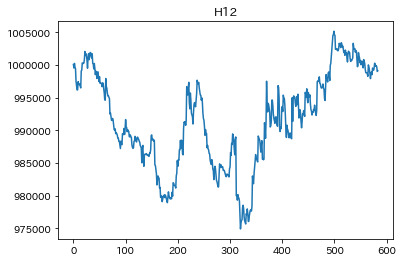

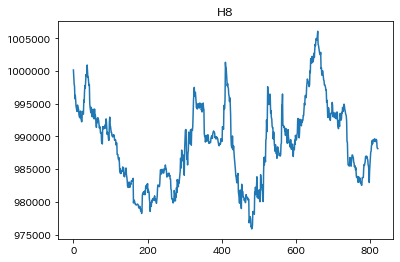

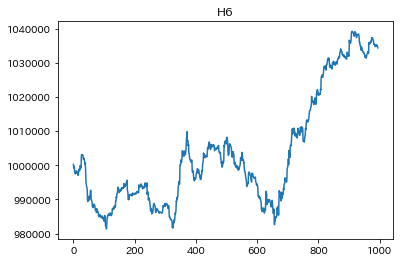

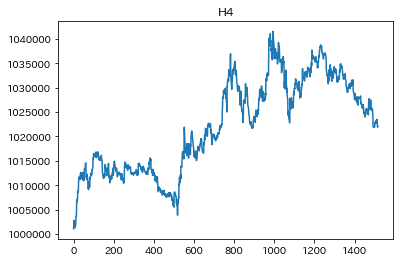

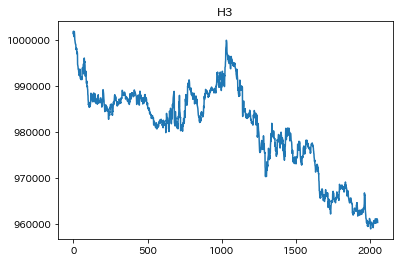

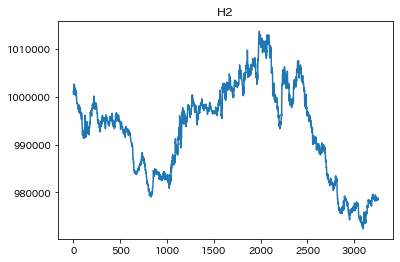

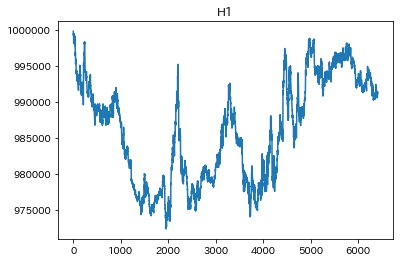

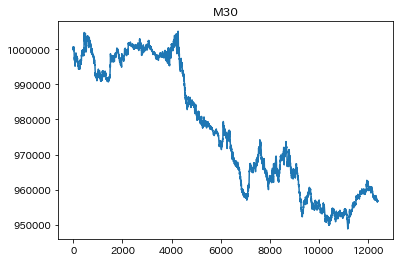

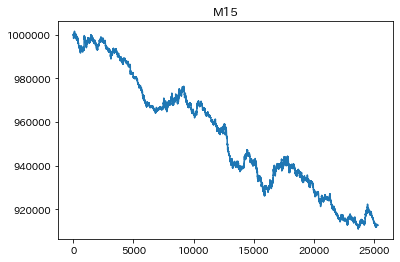

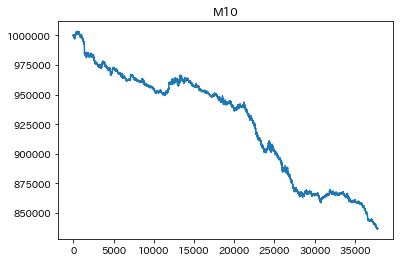

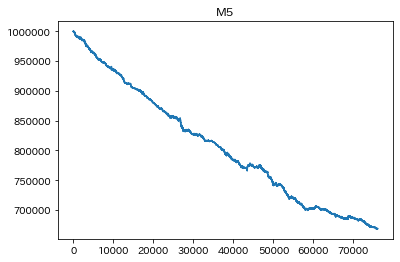

In [34]:
for i in range(len(gran_df3)):
    plt.plot(pos_list3[i]['assets'])
    plt.title(gran_df3.iat[i, 0])
    plt.show()